In [ ]:
import os
os.chdir('/content/drive/MyDrive/LLM-for-code-intelligence-Project/LLM-for-code-intelligence/Evaluation/Perplexity')

import json
import torch
import pickle
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelWithLMHead

global DEVICE
global MODEL
global TOKENIZER
global MAX_LENGTH

def get_perplexity(text, stride):
    encodings = TOKENIZER(text, return_tensors="pt").to(DEVICE)
    seq_len = encodings.input_ids.size(1)
    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + MAX_LENGTH, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(DEVICE)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        with torch.no_grad():
            outputs = MODEL(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl

def save_github_code_eval_subset(language, license, size=1000, shuffle=True):
    """
    Saves a subset of the github code dataset to be used for evaluation.
    :param language: Programming language of the code
    :param license: License of the code
    :param size: Size of the subset
    :param shuffle: Whether to shuffle the dataset before taking the subset
    :return: None
    """
    print(f"Getting codepaarot/github-code dataset for {language} with {license} license and {size} samples from HuggingFace...")
    ds = load_dataset("codeparrot/github-code", languages=[language], licenses=[license], streaming=True, split="train")
    if shuffle:
        ds = ds.shuffle(buffer_size=size)
    ds = ds.take(size)
    evaluation_dataset = []

    for item in tqdm(ds, total=size, desc="Saving evaluation data Locally"):
        evaluation_dataset.append(item['code'])

    eval_data_name = f"./data/evaluation_data_{language}_{license}_{size}.pkl"

    with open(eval_data_name, 'wb') as f:
        pickle.dump(evaluation_dataset, f)


def load_saved_github_code_eval_subset(language, license, size=1000):
    """
    Loads a subset of the github code dataset to be used for evaluation.
    :param language: Programming language of the code
    :param license: License of the code
    :param size: Size of the subset
    :return: None
    """
    eval_data_name = f"./data/evaluation_data_{language}_{license}_{size}.pkl"
    if not os.path.exists(eval_data_name):
        print(f"Saved evaluation data NOT found. Saving now...")
        save_github_code_eval_subset(language, license, size)
    else:
        print(f"FOUND saved evaluation data")
    with open(eval_data_name, 'rb') as f:
        evaluation_dataset = pickle.load(f)
    return evaluation_dataset


def save_results_dict(results_dict, language, license, stride, res_dir):
    """
    Saves a results dictionary to be used for evaluation to a json file.
    :param results_dict: Dictionary containing the results
    :param language: Programming language of the code
    :param license: License of the code
    :param size: Size of the subset
    :param res_dir: Directory to save the results
    :return: None
    """
    #check if directory name results exists
    if not os.path.exists('results'):
        os.makedirs('results')
    #check if res_dir exists in results
    final_res_dir = f"./results/{res_dir}"
    if not os.path.exists(final_res_dir):
        os.makedirs(final_res_dir)
    results_name = f"{final_res_dir}/results_{language}_{license}_{stride}.json"
    results_name_short = f"{final_res_dir}/results_{language}_{license}_{stride}_short.json"

    with open(results_name, 'w') as f:
        json.dump(results_dict, f)
    print(f"Saved results to {results_name}")

    # Delete text to save space
    del results_dict['text']
    with open(results_name_short, 'w') as f:
        json.dump(results_dict, f)
    print(f"Saved short results to {results_name_short}")


def main(languages, licenses, stride, size=10000, n_samples=None, res_dir='base'):
    lang_tbar = tqdm(languages, total=len(languages), unit='Language', position=0, leave=True)
    for language in lang_tbar:
        lang_tbar.set_description(f'Current language: {language}')
        license_tbar = tqdm(licenses, total=len(licenses), unit='License', position=1, leave=True)
        for license in license_tbar:
            license_tbar.set_description(f'Current license: {license}')

            print(f"Loading Evaluation Data for {language} with {license} license and {size} samples...")
            eval_data = load_saved_github_code_eval_subset(language, license, size)


            n_samples = len(eval_data) if n_samples is None else n_samples
            ppl = 0
            current_text_len = 0
            results = {'text': [], 'perplexity': []}

            tbar = tqdm(range(n_samples),total=n_samples, unit='Sample', position=0, leave=True, desc=f'Current perplexity: {ppl:.2f}| Current text length: {current_text_len}')
            for i in tbar:
                text = eval_data[i]
                current_text_len = len(text)
                ppl = get_perplexity(text, stride)
                results['text'].append(text[100:])
                results['perplexity'].append(ppl.item())
                tbar.set_description(f'Current perplexity: {ppl:.2f}| Current text length: {current_text_len}')
                tbar.refresh()

            # Save results
            results['avg_perplexity'] = sum(results['perplexity'])/len(results['perplexity'])
            save_results_dict(results, language, license, stride, res_dir)
            print(f"Average perplexity: {results['avg_perplexity']:.2f}")
            print('='*50)


### Baseline

In [ ]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Salesforce/codegen-350M-mono"
MODEL = AutoModelWithLMHead.from_pretrained(model_name).to(DEVICE)
TOKENIZER = AutoTokenizer.from_pretrained(model_name)
MAX_LENGTH = MODEL.config.n_positions


In [ ]:
languages = ['Python', 'Java']
licenses = ['mit', 'apache-2.0']
stride = 1024
n_samples = 100
size = 100
main(languages, licenses, stride,size=size, n_samples=n_samples)

#### LoRa

In [ ]:
from peft import PeftConfig, PeftModel
from transformers import AutoModelForCausalLM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "ammarnasr/codegne-finetuned-LoRa-the-stack-java-v2-checkpoint-200"
config = PeftConfig.from_pretrained(model_name)


TOKENIZER = AutoTokenizer.from_pretrained(config.base_model_name_or_path)


ckpt =  AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, trust_remote_code=True, use_cache=False)
ckpt.enable_input_require_grads()
MODEL = PeftModel.from_pretrained(ckpt, model_name)
for name, param in MODEL.named_parameters():
  if 'lora' in name:
    param.requires_grad = True
MODEL = MODEL.to(DEVICE)
MODEL.print_trainable_parameters()


MAX_LENGTH = MODEL.config.n_positions

#### Visualize The Results

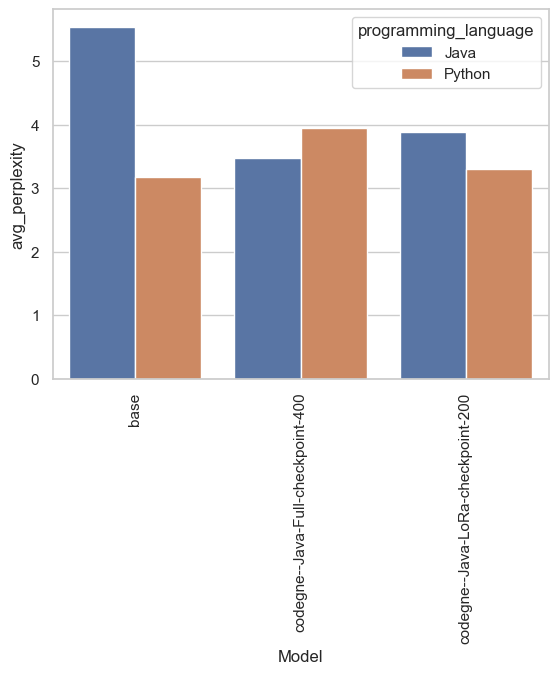

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import os


# Read the folder names inside the results folder
results_dir = './results'
models_dirs = os.listdir(results_dir)
# print(models_dirs)

# Read the results json files that are inside each folder 
results = {}
for model_dir in models_dirs:
    model_dir_path = os.path.join(results_dir, model_dir)
    results[model_dir] = {}
    for file in os.listdir(model_dir_path):
        if file.endswith('.json'):
            file_path = os.path.join(model_dir_path, file)
            with open(file_path, 'r') as f:
                results[model_dir][file[:-5]] = json.load(f)


df_dict = {
    'Model': [],
    'programming_language': [],
    'license': [],
    'stride': [],
    'avg_perplexity': []
}

for model_dir in results:
    for file in results[model_dir]:
        if 'short' in file:
            continue
        df_dict['Model'].append(model_dir)
        df_dict['programming_language'].append(file.split('_')[1])
        df_dict['license'].append(file.split('_')[2])
        df_dict['stride'].append(file.split('_')[3])
        df_dict['avg_perplexity'].append(results[model_dir][file]['avg_perplexity'])

df = pd.DataFrame(df_dict)
df['avg_perplexity'] = df['avg_perplexity'].astype(float)
df['stride'] = df['stride'].astype(int)
df['Model'] = df['Model'].astype(str)
df['programming_language'] = df['programming_language'].astype(str)
df['license'] = df['license'].astype(str)

#drop license column
df = df.drop(columns=['license'])

#drop stride column
df = df.drop(columns=['stride'])

#create new df_dict
df_dict = {
    'Model': [],
    'programming_language': [],
    'avg_perplexity': []
}

#group by model and programming language
df_grouped = df.groupby(['Model', 'programming_language']).mean().reset_index()

#add to df_dict
df_dict['Model'] = df_grouped['Model']
df_dict['programming_language'] = df_grouped['programming_language']
df_dict['avg_perplexity'] = df_grouped['avg_perplexity']

#convert to dataframe
df = pd.DataFrame(df_dict)


# Plot the results
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Model", y="avg_perplexity", hue="programming_language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()